# Pierce - Diversity Metrics
Author: Leo Joseph (l1joseph@ucsd.edu)

Note: All data here is filtered using Zebra

In [1]:
import pandas as pd
# import qupid
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

# qiime2 imports
import qiime2 as q2
from qiime2 import Artifact, Metadata, Visualization
from qiime2.plugins.feature_table.methods import filter_features, filter_samples
import qiime2.plugins.diversity.actions as diversity_actions


# birdman imports
import biom
import numpy as np


Exception ignored in: OpenBLAS blas_thread_init: pthread_create failed for thread 1 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 250 current, 250 max
<bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f0a5626c700>>
Traceback (most recent call last):
  File "/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
OpenBLAS blas_thread_init: pthread_create failed for thread 2 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 250 current, 250 max
OpenBLAS blas_thread_init: pthread_create failed for thread 3 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 250 current, 250 max
OpenBLAS blas_thread_init: pthread_create failed for thread 4 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 250 current, 250 max
OpenBLAS blas_thr

: 

: 

## Applying Coverage Filter Using Zebra

and then recalculating Diversity Metrics

In [ ]:
# load table
table = q2.Artifact.import_data('FeatureTable[Frequency]', 'qiita/195330_none.biom')
metadata = q2.Metadata.load('qiita/15350_20240110-175840.txt')

# load coverages
coverages = pd.read_csv("qiita/195330_coverages/coverage_percentage.txt", sep='\t', index_col=0, header=None)

In [ ]:
def filter_table_by_coverage(feature_table, coverages_df, coverage_threshold):
    """
    Filter the feature table by a given coverage threshold.

    Parameters:
    - feature_table: QIIME 2 Artifact of type 'FeatureTable[Frequency]'
    - coverages_df: pandas DataFrame with coverages, index are OGUs, column 1 is the coverage percentage
    - coverage_threshold: float, minimum coverage percentage to retain an OGU

    Returns:
    - int, the number of OGUs remaining after filtering
    """
    # filter the coverages DataFrame to retain only OGUs above the given threshold
    filtered_ogus = coverages_df[coverages_df[1] >= coverage_threshold].index.tolist()

    # convert the list of OGUs to QIIME 2 Metadata for filtering
    filtered_metadata = Metadata(pd.DataFrame(index=pd.Index(filtered_ogus, name='id')))
    
    # filter the feature table
    filtered_table, = filter_features(table, metadata=filtered_metadata)
    
    # get the number of features (OGUs) remaining after filtering
    filtered_table_df = filtered_table.view(pd.DataFrame)
    remaining_ogus = filtered_table_df.shape[1]  # features are columns
    
    return remaining_ogus

In [ ]:
coverage_thresholds = np.arange(1, 100)  # 1% to 100%

# record the number of OGUs remaining for each coverage threshold
ogus_remaining = []
for threshold in coverage_thresholds:
    remaining = filter_table_by_coverage(table, coverages, threshold)
    ogus_remaining.append(remaining)

In [ ]:
print(threshold)
print(ogus_remaining)
print(coverage_thresholds)

99
[1533, 1145, 990, 878, 795, 753, 715, 677, 648, 632, 608, 570, 554, 542, 523, 514, 508, 505, 495, 486, 479, 472, 466, 458, 451, 447, 440, 436, 432, 428, 422, 418, 412, 411, 408, 403, 397, 395, 392, 389, 386, 383, 379, 379, 375, 371, 366, 362, 362, 361, 361, 355, 355, 353, 349, 345, 343, 340, 339, 331, 328, 328, 322, 320, 317, 313, 312, 308, 304, 303, 302, 297, 296, 292, 290, 288, 288, 285, 281, 277, 276, 270, 261, 259, 255, 246, 241, 239, 229, 220, 208, 194, 184, 161, 142, 112, 84, 60, 29]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]


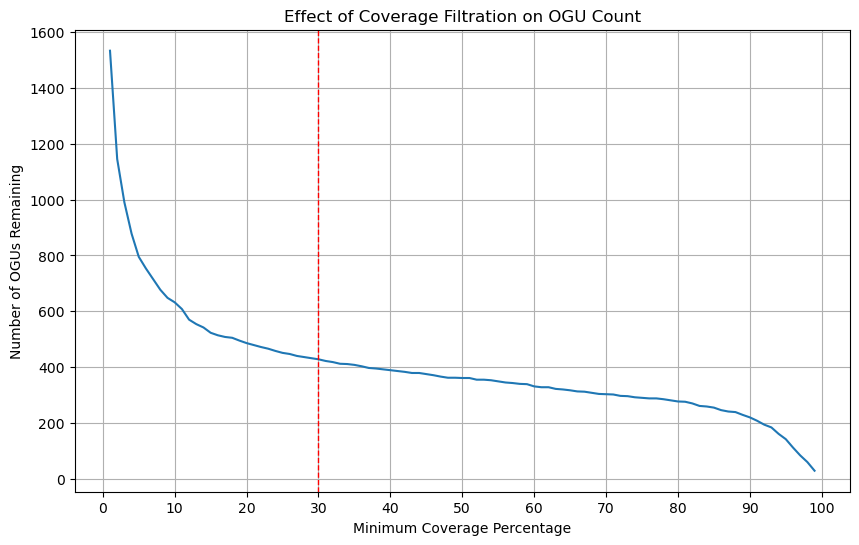

In [ ]:
# plot coverage as line graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=coverage_thresholds, y=ogus_remaining)
plt.title('Effect of Coverage Filtration on OGU Count')
plt.xlabel('Minimum Coverage Percentage')
plt.ylabel('Number of OGUs Remaining')
plt.xticks(np.arange(0, 101, 10))
plt.axvline(30, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

In [ ]:
threshold = 30 # percentage
filtered_ogus = coverages[coverages[1] >= threshold].index.tolist()
filtered_metadata = Metadata(pd.DataFrame(index=pd.Index(filtered_ogus, name='id')))
filtered_table, = filter_features(table, metadata=filtered_metadata)

# blank filter
# TODO: ScRUB?
metadata_df = metadata.to_dataframe()
filtered_metadata_df = metadata_df[~metadata_df.index.str.contains('BLANK')]
filtered_metadata = q2.Metadata(filtered_metadata_df)
filtered_table, = filter_samples(table=filtered_table, metadata=filtered_metadata)
filtered_table.save("data/195330_zebra.qza"  )

'data/195330_zebra.qza'

In [ ]:
filtered_biom_path = 'data/195330_zebra.biom'
filtered_table_artifact = q2.Artifact.load("out/195330_zebra.qza")
filtered_table_artifact.export_data(filtered_biom_path)

In [ ]:
filtered_metadata_df.to_csv('data/195330_zebra_metadata.tsv', sep='\t')
post_zebra = filtered_metadata.to_dataframe()

# Rerun diversity metrics & stats after applying coverage filter

In [ ]:
table = Artifact.import_data("FeatureTable[Frequency]", "data/195330_zebra.biom/feature-table.biom")
phylogeny = Artifact.import_data("Phylogeny[Rooted]", "/projects/wol/qiyun/wol2/phylogeny/tree.nwk")
sampling_depth = 500000
metadata = Metadata.load("qiita/15350_20240110-175840.txt")

In [ ]:
action_results = diversity_actions.core_metrics_phylogenetic(
    phylogeny=phylogeny,
    table=table,
    sampling_depth=sampling_depth,
    metadata=metadata,
)

rarefied_table = action_results.rarefied_table
faith_pd_vector = action_results.faith_pd_vector
observed_features_vector = action_results.observed_features_vector
shannon_vector = action_results.shannon_vector
evenness_vector = action_results.evenness_vector
unweighted_unifrac_distance_matrix = action_results.unweighted_unifrac_distance_matrix
weighted_unifrac_distance_matrix = action_results.weighted_unifrac_distance_matrix
jaccard_distance_matrix = action_results.jaccard_distance_matrix
bray_curtis_distance_matrix = action_results.bray_curtis_distance_matrix
unweighted_unifrac_pcoa_results = action_results.unweighted_unifrac_pcoa_results
weighted_unifrac_pcoa_results = action_results.weighted_unifrac_pcoa_results
jaccard_pcoa_results = action_results.jaccard_pcoa_results
bray_curtis_pcoa_results = action_results.bray_curtis_pcoa_results
unweighted_unifrac_emperor_viz = action_results.unweighted_unifrac_emperor
weighted_unifrac_emperor_viz = action_results.weighted_unifrac_emperor
jaccard_emperor_viz = action_results.jaccard_emperor
bray_curtis_emperor_viz = action_results.bray_curtis_emperor

/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.013796922935573592 and the largest is 0.46102593315960444.
  warn(
/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /tmp/qiime2/l1joseph/data/dc9ef435-7de2-4ac9-a2e4-14a13518f7c0/data/feature-table.biom -t /tmp/qiime2/l1joseph/data/b7d63c7f-a95e-4534-8b1c-162f605c33df/data/tree.nwk -o /tmp/q2-AlphaDiversityFormat-vjhj228u

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /tmp/qiime2/l1joseph/data/dc9ef435-7de2-4ac9-a2e4-14a13518f7c0/data/feature-table.biom -t /tmp/qiime2/l1joseph/data/b7d63c7f-a95e-4534-8b1c-162f605c33df/data/tree.nwk -m unweighted -o /tmp/q2-LSMatFormat-bia1u3f2

Running external command line application. This may print messages to stdout and/or stderr.
T

/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.013870991181659891 and the largest is 0.2617607729143987.
  warn(
/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See 

In [ ]:
faith_pd_group_significance_viz, = diversity_actions.alpha_group_significance(
    alpha_diversity=faith_pd_vector,
    metadata=metadata,
)
evenness_group_significance_viz, = diversity_actions.alpha_group_significance(
    alpha_diversity=evenness_vector,
    metadata=metadata,
)

In [ ]:
if not os.path.exists(f'data/zebra30'):
    os.makedirs(f'data/zebra30')

rarefied_table.save(f'data/zebra30/rarefied_table.qza')
faith_pd_vector.save(f'data/zebra30/faith_pd_vector.qza')
observed_features_vector.save(f'data/zebra30/observed_features_vector.qza')
shannon_vector.save(f'data/zebra30/shannon_vector.qza')
evenness_vector.save(f'data/zebra30/evenness_vector.qza')
unweighted_unifrac_distance_matrix.save(f'data/zebra30/unweighted_unifrac_distance_matrix.qza')
weighted_unifrac_distance_matrix.save(f'data/zebra30/weighted_unifrac_distance_matrix.qza')
jaccard_distance_matrix.save(f'data/zebra30/jaccard_distance_matrix.qza')
bray_curtis_distance_matrix.save(f'data/zebra30/bray_curtis_distance_matrix.qza')
unweighted_unifrac_pcoa_results.save(f'data/zebra30/unweighted_unifrac_pcoa_results.qza')
weighted_unifrac_pcoa_results.save(f'data/zebra30/weighted_unifrac_pcoa_results.qza')
jaccard_pcoa_results.save(f'data/zebra30/jaccard_pcoa_results.qza')
bray_curtis_pcoa_results.save(f'data/zebra30/bray_curtis_pcoa_results.qza')
unweighted_unifrac_emperor_viz.save(f'data/zebra30/unweighted_unifrac_emperor.qzv')
weighted_unifrac_emperor_viz.save(f'data/zebra30/weighted_unifrac_emperor.qzv')
jaccard_emperor_viz.save(f'data/zebra30/jaccard_emperor.qzv')
bray_curtis_emperor_viz.save(f'data/zebra30/bray_curtis_emperor.qzv')

'data/zebra30/bray_curtis_emperor.qzv'

In [ ]:
faith_pd_group_significance_viz.save(f'data/zebra30/faith_pd_group_significance.qzv')
evenness_group_significance_viz.save(f'data/zebra30/evenness_group_significance.qzv')

'data/zebra30/evenness_group_significance.qzv'

## Using biom table from lucas

In [ ]:
table = Artifact.import_data("FeatureTable[Frequency]", "out/lucas/195330_zebra.biom")
phylogeny = Artifact.import_data("Phylogeny[Rooted]", "/projects/wol/qiyun/wol2/phylogeny/tree.nwk")
sampling_depth = 500000
metadata = Metadata.load("qiita/15350_20240110-175840.txt")

In [ ]:
action_results = diversity_actions.core_metrics_phylogenetic(
    phylogeny=phylogeny,
    table=table,
    sampling_depth=sampling_depth,
    metadata=metadata,
)

rarefied_table = action_results.rarefied_table
faith_pd_vector = action_results.faith_pd_vector
observed_features_vector = action_results.observed_features_vector
shannon_vector = action_results.shannon_vector
evenness_vector = action_results.evenness_vector
unweighted_unifrac_distance_matrix = action_results.unweighted_unifrac_distance_matrix
weighted_unifrac_distance_matrix = action_results.weighted_unifrac_distance_matrix
jaccard_distance_matrix = action_results.jaccard_distance_matrix
bray_curtis_distance_matrix = action_results.bray_curtis_distance_matrix
unweighted_unifrac_pcoa_results = action_results.unweighted_unifrac_pcoa_results
weighted_unifrac_pcoa_results = action_results.weighted_unifrac_pcoa_results
jaccard_pcoa_results = action_results.jaccard_pcoa_results
bray_curtis_pcoa_results = action_results.bray_curtis_pcoa_results
unweighted_unifrac_emperor_viz = action_results.unweighted_unifrac_emperor
weighted_unifrac_emperor_viz = action_results.weighted_unifrac_emperor
jaccard_emperor_viz = action_results.jaccard_emperor
bray_curtis_emperor_viz = action_results.bray_curtis_emperor

/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.01380962508233354 and the largest is 0.42536164120966435.
  warn(
/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See 

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /tmp/qiime2/l1joseph/data/4752252c-9324-456f-af39-abe562862d5c/data/feature-table.biom -t /tmp/qiime2/l1joseph/data/14e235ed-dd59-496a-ae90-54881c1416ac/data/tree.nwk -o /tmp/q2-AlphaDiversityFormat-as16h7d1

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /tmp/qiime2/l1joseph/data/4752252c-9324-456f-af39-abe562862d5c/data/feature-table.biom -t /tmp/qiime2/l1joseph/data/14e235ed-dd59-496a-ae90-54881c1416ac/data/tree.nwk -m unweighted -o /tmp/q2-LSMatFormat-t_chj96x

Running external command line application. This may print messages to stdout and/or stderr.
T

/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.015959873541828276 and the largest is 0.2176432524094448.
  warn(
/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See 

In [ ]:
if not os.path.exists(f'out/lucas/zebra30'):
    os.makedirs(f'out/lucas/zebra30')

rarefied_table.save(f'out/lucas/zebra30/rarefied_table.qza')
faith_pd_vector.save(f'out/lucas/zebra30/faith_pd_vector.qza')
observed_features_vector.save(f'out/lucas/zebra30/observed_features_vector.qza')
shannon_vector.save(f'out/lucas/zebra30/shannon_vector.qza')
evenness_vector.save(f'out/lucas/zebra30/evenness_vector.qza')
unweighted_unifrac_distance_matrix.save(f'out/lucas/zebra30/unweighted_unifrac_distance_matrix.qza')
weighted_unifrac_distance_matrix.save(f'out/lucas/zebra30/weighted_unifrac_distance_matrix.qza')
jaccard_distance_matrix.save(f'out/lucas/zebra30/jaccard_distance_matrix.qza')
bray_curtis_distance_matrix.save(f'out/lucas/zebra30/bray_curtis_distance_matrix.qza')
unweighted_unifrac_pcoa_results.save(f'out/lucas/zebra30/unweighted_unifrac_pcoa_results.qza')
weighted_unifrac_pcoa_results.save(f'out/lucas/zebra30/weighted_unifrac_pcoa_results.qza')
jaccard_pcoa_results.save(f'out/lucas/zebra30/jaccard_pcoa_results.qza')
bray_curtis_pcoa_results.save(f'out/lucas/zebra30/bray_curtis_pcoa_results.qza')
unweighted_unifrac_emperor_viz.save(f'out/lucas/zebra30/unweighted_unifrac_emperor.qzv')
weighted_unifrac_emperor_viz.save(f'out/lucas/zebra30/weighted_unifrac_emperor.qzv')
jaccard_emperor_viz.save(f'out/lucas/zebra30/jaccard_emperor.qzv')
bray_curtis_emperor_viz.save(f'out/lucas/zebra30/bray_curtis_emperor.qzv')

'out/lucas/zebra30/bray_curtis_emperor.qzv'

In [ ]:
faith_pd_group_significance_viz.save(f'out/lucas/zebra30/faith_pd_group_significance.qzv')
evenness_group_significance_viz.save(f'out/lucas/zebra30/evenness_group_significance.qzv')

'out/lucas/zebra30/evenness_group_significance.qzv'

## Creating New Figures and Stat tests based on Filtered Data

#### Read in Data

In [ ]:
z_metadata = pd.read_table("data/Metadata.tsv", sep="\t", index_col=0)
z_fpd = Artifact.load('out/lucas/zebra30/faith_pd_vector.qza') 

In [ ]:
z_metadata['ados_cosototrrtot'] = z_metadata['ados_cosototrrtot'].astype(int)
z_metadata['ados_cosotot'] = z_metadata['ados_cosotot'].astype(int)
z_metadata['ados_rrtot'] = z_metadata['ados_rrtot'].astype(int)
z_metadata['dna_extracted'] = z_metadata['dna_extracted'].astype(int)

In [ ]:
z_asd_fpd = z_metadata.join(z_fpd.view(pd.Series))

### Using Qupid

/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


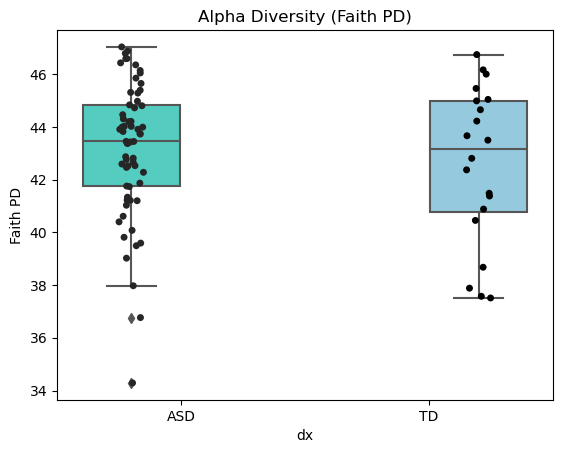

In [ ]:
sns.boxplot(x='dx', y='faith_pd', data=z_asd_fpd, hue='dx', palette=['turquoise', 'skyblue'])
sns.stripplot(x='dx', y='faith_pd', data=z_asd_fpd, hue='dx', dodge=True, jitter=True, color='black') 

plt.title('Alpha Diversity (Faith PD)')
plt.ylabel('Faith PD')
plt.legend(loc='upper center', fontsize = "7").set_visible(False)
plt.show()

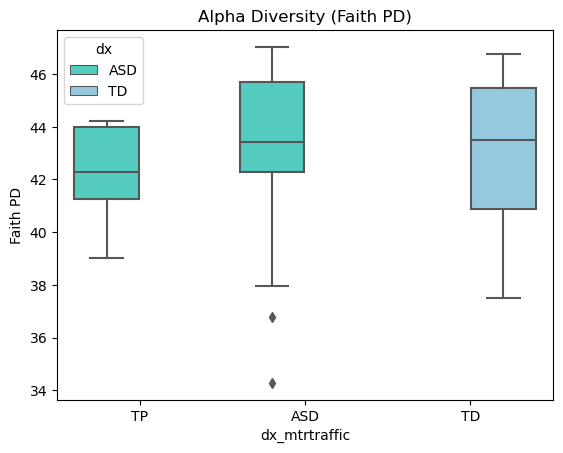

In [ ]:
sns.boxplot(x='dx_mtrtraffic', y='faith_pd', data=z_asd_fpd, hue='dx', palette=['turquoise', 'skyblue'])

plt.title('Alpha Diversity (Faith PD)')
plt.ylabel('Faith PD')
plt.show()


CCM

In [ ]:
asd_str = "TP"
no_asd_str = "TD"

background = z_asd_fpd.query("dx_mtrtraffic == @no_asd_str")
focus = z_asd_fpd.query("dx_mtrtraffic == @asd_str")
# focus.drop(index='15350.A7L6P.1', inplace=True)
# focus.drop(index='15350.C3Z7C.1', inplace=True)


matches = qupid.shuffle(
    focus=focus,
    background=background,
    categories=["host_age"],
    tolerance_map={"host_age": 5},
    iterations=1000,
    on_failure="ignore"
)

/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/qupid/qupid.py:49: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for f_idx, f_val in focus.iteritems():


/tmp/ipykernel_9427/2064669533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_asd_tp_df['Group'] = 'ASD-TP'
/tmp/ipykernel_9427/2064669533.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_asd_tp_df['Group'] = 'ASD-TP'


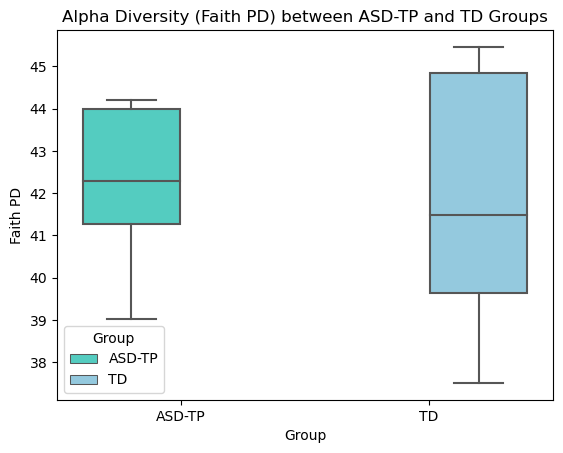

Kruskal-Wallis Test Statistic: 0.10204081632652873, p-value: 0.7493941849625727


In [ ]:
# Filter for ASD-TP group
z_asd_tp_df = z_asd_fpd[z_asd_fpd['dx_mtrtraffic'] == 'TP']
z_td_df = z_asd_fpd[z_asd_fpd['dx_mtrtraffic'] == 'TD'].sample(n=len(z_asd_tp_df), random_state=42)

z_asd_tp_df['Group'] = 'ASD-TP'
z_td_df['Group'] = 'TD'

# Concatenate the two DataFrames and add a new column to label the groups
z_asd_tp_df['Group'] = 'ASD-TP'
z_td_df['Group'] = 'TD'
z_combined_df = pd.concat([z_asd_tp_df, z_td_df])

# Plotting
sns.boxplot(x='Group', y='faith_pd', data=z_combined_df, hue='Group', palette=['turquoise', 'skyblue'])
plt.title('Alpha Diversity (Faith PD) between ASD-TP and TD Groups')
plt.ylabel('Faith PD')
plt.show()

# Extracting Faith PD values for each group
z_faith_pd_asd_tp = z_combined_df[z_combined_df['Group'] == 'ASD-TP']['faith_pd']
z_faith_pd_td = z_combined_df[z_combined_df['Group'] == 'TD']['faith_pd']

# Kruskal-Wallis Test
stat1, p1 = kruskal(z_faith_pd_asd_tp, z_faith_pd_td)
print(f'Kruskal-Wallis Test Statistic: {stat1}, p-value: {p1}')

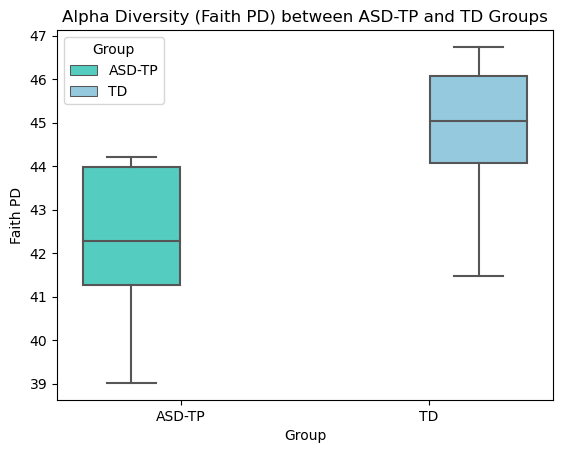

Kruskal-Wallis Test Statistic: 5.0, p-value: 0.025347318677468325


In [ ]:
# Filter asd_md for ASD-TP and TD groups
z_asd_tp_df = z_asd_fpd.loc[matches[0].index]
z_td_df = z_asd_fpd.loc[matches[0].values]

# Concatenate the two DataFrames and add a new column to label the groups
z_asd_tp_df['Group'] = 'ASD-TP'
z_td_df['Group'] = 'TD'
z_combined_df = pd.concat([z_asd_tp_df, z_td_df])

# Plotting
sns.boxplot(x='Group', y='faith_pd', data=z_combined_df, hue='Group', palette=['turquoise', 'skyblue'])
plt.title('Alpha Diversity (Faith PD) between ASD-TP and TD Groups')
plt.ylabel('Faith PD')
plt.show()

# Extracting Faith PD values for each group
z_faith_pd_asd_tp = z_combined_df[z_combined_df['Group'] == 'ASD-TP']['faith_pd']
z_faith_pd_td = z_combined_df[z_combined_df['Group'] == 'TD']['faith_pd']

# Kruskal-Wallis Test
stat2, p2 = kruskal(z_faith_pd_asd_tp, z_faith_pd_td)
print(f'Kruskal-Wallis Test Statistic: {stat2}, p-value: {p2}')

In [ ]:
print(f'Using Zebra for coverage filtering')
print(f'Before Case-Control Matching using Qupid: ')
print(f'Kruskal-Wallis Test Statistic: {stat1}, p-value: {p1}\n')
print(f'After Case-Control Matching using Qupid: ')
print(f'Kruskal-Wallis Test Statistic: {stat2}, p-value: {p2}')

Using Zebra for coverage filtering
Before Case-Control Matching using Qupid: 
Kruskal-Wallis Test Statistic: 0.10204081632652873, p-value: 0.7493941849625727

After Case-Control Matching using Qupid: 
Kruskal-Wallis Test Statistic: 0.03673469387754835, p-value: 0.8480062142193152


### AVG QUPID MATCHING

In [ ]:
asd_str = "TP"
no_asd_str = "TD"

background = z_asd_fpd.query("dx_mtrtraffic == @no_asd_str")
focus = z_asd_fpd.query("dx_mtrtraffic == @asd_str")
# focus.drop(index='15350.A7L6P.1', inplace=True)
# focus.drop(index='15350.C3Z7C.1', inplace=True)


sm = qupid.shuffle(
    focus=focus,
    background=background,
    categories=["host_age"],
    tolerance_map={"host_age": 5},
    iterations=1000,
    on_failure="ignore"
)

/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/qupid/qupid.py:49: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for f_idx, f_val in focus.iteritems():


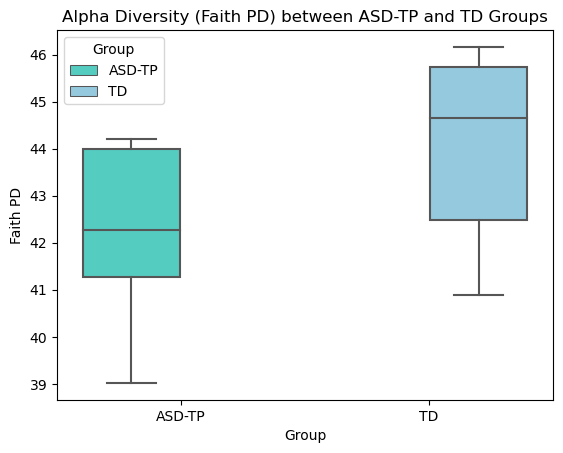

Kruskal-Wallis Test Statistic: 2.1591836734693857, p-value: 0.14171996321058591


In [ ]:
# Filter asd_md for ASD-TP and TD groups
z_asd_tp_df = z_asd_fpd.loc[sm[0].index]
z_td_df = z_asd_fpd.loc[sm[0].values]

# Concatenate the two DataFrames and add a new column to label the groups
z_asd_tp_df['Group'] = 'ASD-TP'
z_td_df['Group'] = 'TD'
z_combined_df = pd.concat([z_asd_tp_df, z_td_df])

# Plotting
sns.boxplot(x='Group', y='faith_pd', data=z_combined_df, hue='Group', palette=['turquoise', 'skyblue'])
plt.title('Alpha Diversity (Faith PD) between ASD-TP and TD Groups')
plt.ylabel('Faith PD')
plt.show()

# Extracting Faith PD values for each group
z_faith_pd_asd_tp = z_combined_df[z_combined_df['Group'] == 'ASD-TP']['faith_pd']
z_faith_pd_td = z_combined_df[z_combined_df['Group'] == 'TD']['faith_pd']

# Kruskal-Wallis Test
stat2, p2 = kruskal(z_faith_pd_asd_tp, z_faith_pd_td)
print(f'Kruskal-Wallis Test Statistic: {stat2}, p-value: {p2}')

Evenness: Mann-Whitney U statistic = 684.0, p-value = 0.5689049757258753
Faith's PD: Mann-Whitney U statistic = 686.0, p-value = 0.5545466713016844
Observed Features: Mann-Whitney U statistic = 665.5, p-value = 0.7093386094199863
Shannon: Mann-Whitney U statistic = 686.0, p-value = 0.5545466713016844


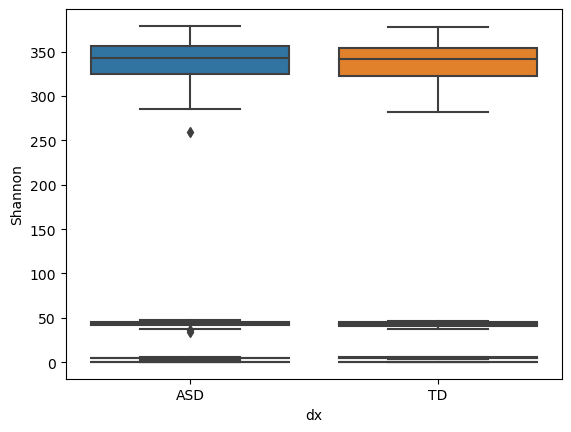

In [ ]:
# Load the alpha diversity vectors
evenness = Artifact.load('out/lucas/zebra30/evenness_vector.qza')
faith_pd = Artifact.load('out/lucas/zebra30/faith_pd_vector.qza')
observed_features = Artifact.load('out/lucas/zebra30/observed_features_vector.qza')
shannon = Artifact.load('out/lucas/zebra30/shannon_vector.qza')

# Convert the alpha diversity vectors to pandas DataFrames
evenness_df = evenness.view(pd.Series).to_frame(name='Evenness')
faith_pd_df = faith_pd.view(pd.Series).to_frame(name='Faith_PD')
observed_features_df = observed_features.view(pd.Series).to_frame(name='Observed_Features')
shannon_df = shannon.view(pd.Series).to_frame(name='Shannon')

# Merge the DataFrames
alpha_diversity_df = pd.concat([evenness_df, faith_pd_df, observed_features_df, shannon_df], axis=1)

# Add metadata if available (assuming you have a metadata file)
metadata = pd.read_table("data/Metadata.tsv", sep="\t", index_col=0)
alpha_diversity_df = alpha_diversity_df.merge(metadata, left_index=True, right_index=True)

# Visualize the alpha diversity metrics using box plots
sns.boxplot(data=alpha_diversity_df, x='dx', y='Evenness')
sns.boxplot(data=alpha_diversity_df, x='dx', y='Faith_PD')
sns.boxplot(data=alpha_diversity_df, x='dx', y='Observed_Features')
sns.boxplot(data=alpha_diversity_df, x='dx', y='Shannon')

# Perform Mann-Whitney U test to compare alpha diversity between groups
group1 = alpha_diversity_df[alpha_diversity_df['dx'] == 'ASD']
group2 = alpha_diversity_df[alpha_diversity_df['dx'] == 'TD']

evenness_stat, evenness_p = mannwhitneyu(group1['Evenness'], group2['Evenness'])
faith_pd_stat, faith_pd_p = mannwhitneyu(group1['Faith_PD'], group2['Faith_PD'])
observed_features_stat, observed_features_p = mannwhitneyu(group1['Observed_Features'], group2['Observed_Features'])
shannon_stat, shannon_p = mannwhitneyu(group1['Shannon'], group2['Shannon'])

print(f"Evenness: Mann-Whitney U statistic = {evenness_stat}, p-value = {evenness_p}")
print(f"Faith's PD: Mann-Whitney U statistic = {faith_pd_stat}, p-value = {faith_pd_p}")
print(f"Observed Features: Mann-Whitney U statistic = {observed_features_stat}, p-value = {observed_features_p}")
print(f"Shannon: Mann-Whitney U statistic = {shannon_stat}, p-value = {shannon_p}")

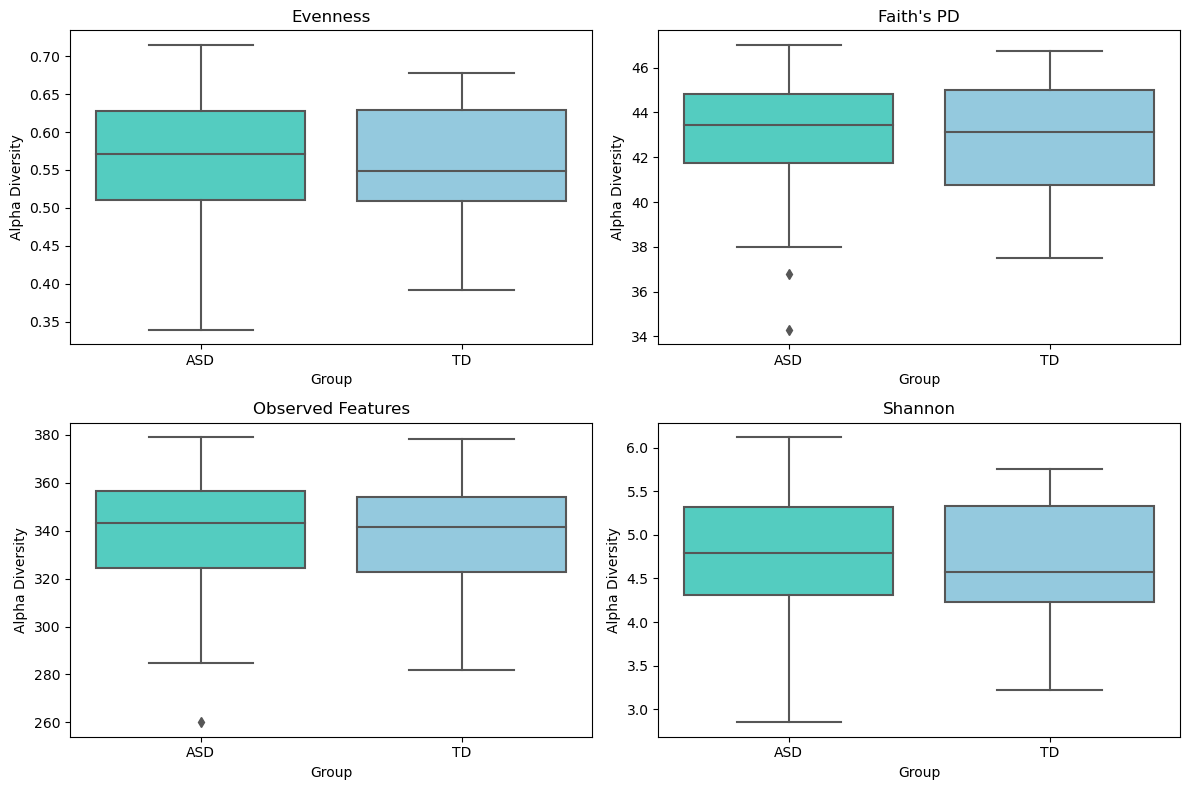

Evenness: Mann-Whitney U statistic = 684.0, p-value = 0.5689049757258753
Faith's PD: Mann-Whitney U statistic = 686.0, p-value = 0.5545466713016844
Observed Features: Mann-Whitney U statistic = 665.5, p-value = 0.7093386094199863
Shannon: Mann-Whitney U statistic = 686.0, p-value = 0.5545466713016844


In [ ]:
# Load the alpha diversity vectors
evenness = Artifact.load('out/lucas/zebra30/evenness_vector.qza')
faith_pd = Artifact.load('out/lucas/zebra30/faith_pd_vector.qza')
observed_features = Artifact.load('out/lucas/zebra30/observed_features_vector.qza')
shannon = Artifact.load('out/lucas/zebra30/shannon_vector.qza')

# Convert the alpha diversity vectors to pandas DataFrames
evenness_df = evenness.view(pd.Series).to_frame(name='Evenness')
faith_pd_df = faith_pd.view(pd.Series).to_frame(name='Faith_PD')
observed_features_df = observed_features.view(pd.Series).to_frame(name='Observed_Features')
shannon_df = shannon.view(pd.Series).to_frame(name='Shannon')

# Merge the DataFrames
alpha_diversity_df = pd.concat([evenness_df, faith_pd_df, observed_features_df, shannon_df], axis=1)

# Add metadata if available (assuming you have a metadata file)
metadata = pd.read_table("data/Metadata.tsv", sep="\t", index_col=0)
alpha_diversity_df = alpha_diversity_df.merge(metadata, left_index=True, right_index=True)

# Set up the plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()

# Visualize the alpha diversity metrics using box plots
sns.boxplot(data=alpha_diversity_df, x='dx', y='Evenness', ax=axs[0], palette=['turquoise', 'skyblue'])
sns.boxplot(data=alpha_diversity_df, x='dx', y='Faith_PD', ax=axs[1], palette=['turquoise', 'skyblue'])
sns.boxplot(data=alpha_diversity_df, x='dx', y='Observed_Features', ax=axs[2], palette=['turquoise', 'skyblue'])
sns.boxplot(data=alpha_diversity_df, x='dx', y='Shannon', ax=axs[3], palette=['turquoise', 'skyblue'])

# Set plot titles and labels
axs[0].set_title('Evenness')
axs[1].set_title('Faith\'s PD')
axs[2].set_title('Observed Features')
axs[3].set_title('Shannon')

for ax in axs:
    ax.set_xlabel('Group')
    ax.set_ylabel('Alpha Diversity')

plt.tight_layout()
plt.show()

# Perform Mann-Whitney U test to compare alpha diversity between groups
group1 = alpha_diversity_df[alpha_diversity_df['dx'] == 'ASD']
group2 = alpha_diversity_df[alpha_diversity_df['dx'] == 'TD']

evenness_stat, evenness_p = mannwhitneyu(group1['Evenness'], group2['Evenness'])
faith_pd_stat, faith_pd_p = mannwhitneyu(group1['Faith_PD'], group2['Faith_PD'])
observed_features_stat, observed_features_p = mannwhitneyu(group1['Observed_Features'], group2['Observed_Features'])
shannon_stat, shannon_p = mannwhitneyu(group1['Shannon'], group2['Shannon'])

print(f"Evenness: Mann-Whitney U statistic = {evenness_stat}, p-value = {evenness_p}")
print(f"Faith's PD: Mann-Whitney U statistic = {faith_pd_stat}, p-value = {faith_pd_p}")
print(f"Observed Features: Mann-Whitney U statistic = {observed_features_stat}, p-value = {observed_features_p}")
print(f"Shannon: Mann-Whitney U statistic = {shannon_stat}, p-value = {shannon_p}")

In [ ]:
# Perform Mann-Whitney U test to compare alpha diversity between groups
group1 = alpha_diversity_df[alpha_diversity_df['dx'] == 'ASD']
group2 = alpha_diversity_df[alpha_diversity_df['dx'] == 'TD']

evenness_stat, evenness_p = mannwhitneyu(group1['Evenness'], group2['Evenness'])
faith_pd_stat, faith_pd_p = mannwhitneyu(group1['Faith_PD'], group2['Faith_PD'])
observed_features_stat, observed_features_p = mannwhitneyu(group1['Observed_Features'], group2['Observed_Features'])
shannon_stat, shannon_p = mannwhitneyu(group1['Shannon'], group2['Shannon'])

print(f"Evenness: Mann-Whitney U statistic = {evenness_stat}, p-value = {evenness_p}")
print(f"Faith's PD: Mann-Whitney U statistic = {faith_pd_stat}, p-value = {faith_pd_p}")
print(f"Observed Features: Mann-Whitney U statistic = {observed_features_stat}, p-value = {observed_features_p}")
print(f"Shannon: Mann-Whitney U statistic = {shannon_stat}, p-value = {shannon_p}")

Evenness: Mann-Whitney U statistic = 655.0, p-value = 0.7941892150565808
Faith's PD: Mann-Whitney U statistic = 715.0, p-value = 0.3682526895650068
Observed Features: Mann-Whitney U statistic = 726.5, p-value = 0.30666983607843723
Shannon: Mann-Whitney U statistic = 673.0, p-value = 0.6508817642701086


### Plots

<AxesSubplot: xlabel='dx_geopref', ylabel='Faith_PD'>

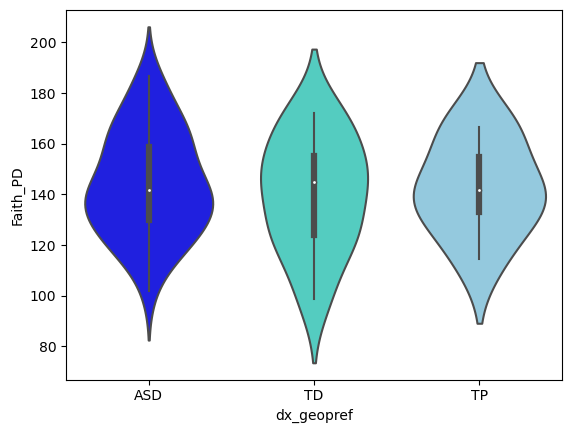

In [ ]:
sns.violinplot(data=alpha_diversity_df, x='dx_geopref', y='Faith_PD', jitter ='true', dodge = 'true', palette=['blue', 'turquoise', 'skyblue'])

<AxesSubplot: xlabel='dx', ylabel='Observed_Features'>

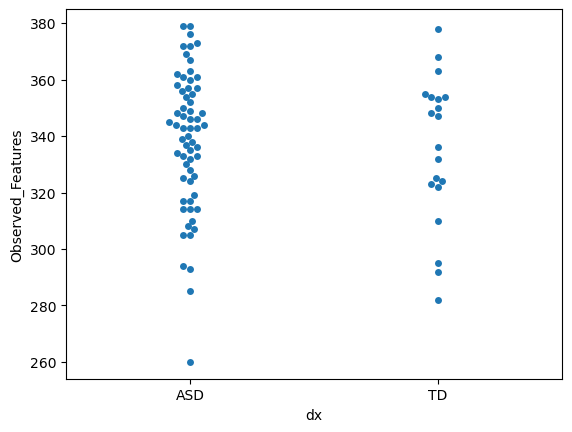

In [ ]:
sns.swarmplot(data=alpha_diversity_df, x='dx', y='Observed_Features')

<AxesSubplot: xlabel='Faith_PD', ylabel='Density'>

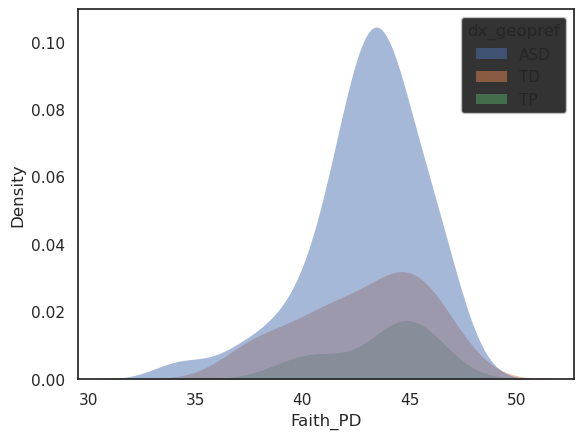

In [ ]:
# overlapping density plot that shows the distribution of alpha diversity metrics across different groups
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.kdeplot(data=alpha_diversity_df, x='Faith_PD', hue='dx_geopref', fill=True, alpha=0.5, linewidth=0)

<Figure size 1000x600 with 0 Axes>

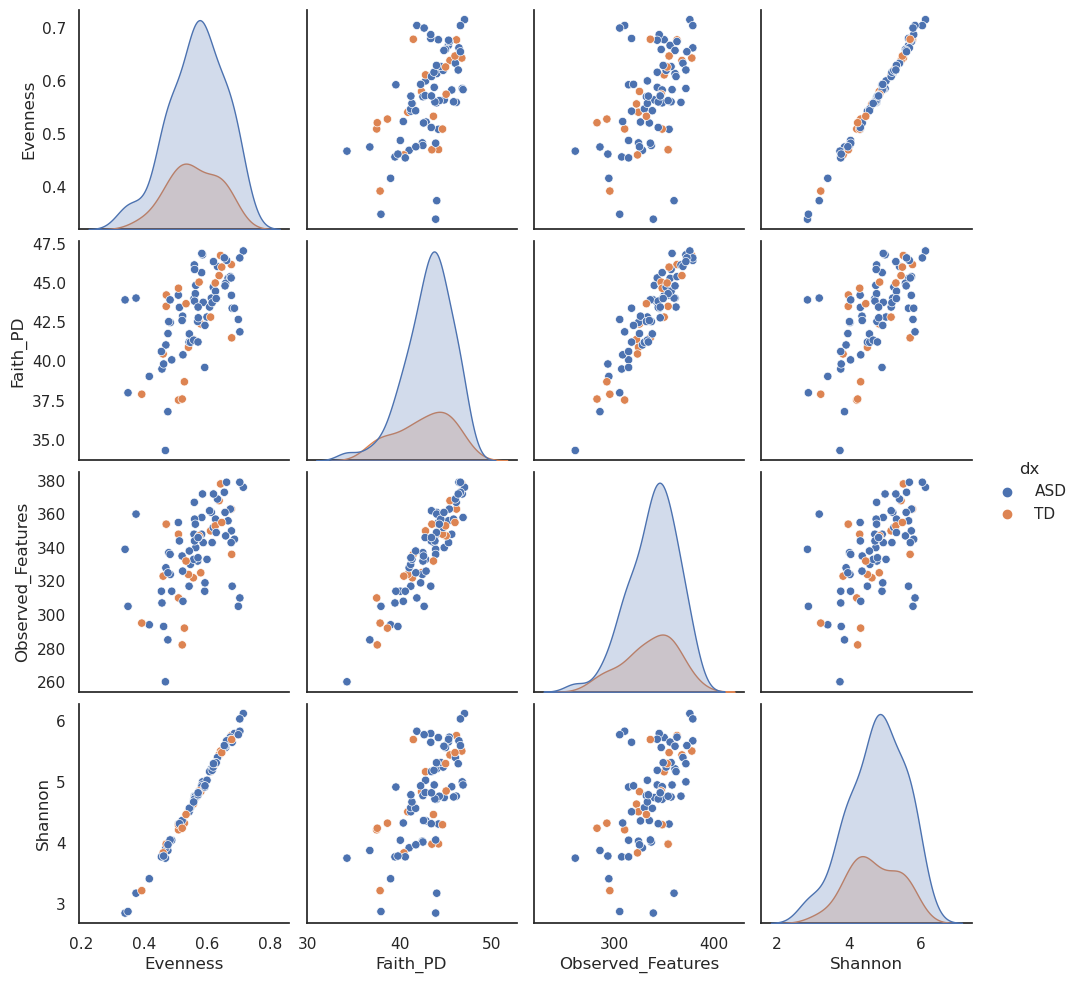

In [ ]:
plt.figure(figsize=(10, 6))
sns.pairplot(alpha_diversity_df, vars=['Evenness', 'Faith_PD', 'Observed_Features', 'Shannon'], hue='dx')
plt.show()

/tmp/ipykernel_9427/3028631783.py:2: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(x='dx', y='Shannon', data=alpha_diversity_df, hue='dx', dodge=True, jitter=True, palette=['black'])


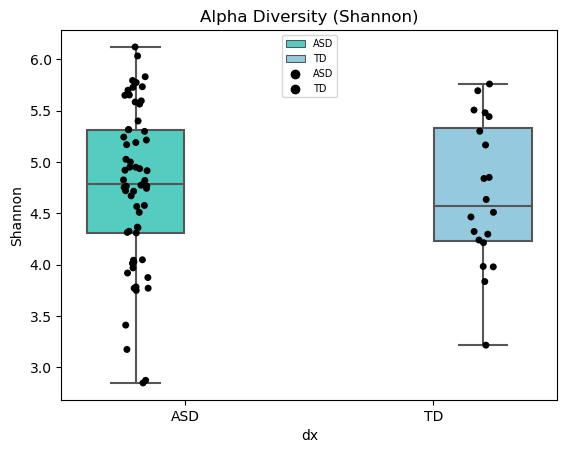

In [ ]:
sns.boxplot(x='dx', y='Shannon', data=alpha_diversity_df, hue='dx', palette=['turquoise', 'skyblue'])
sns.stripplot(x='dx', y='Shannon', data=alpha_diversity_df, hue='dx', dodge=True, jitter=True, palette=['black']) 

plt.title('Alpha Diversity (Shannon)')
plt.ylabel('Shannon')
plt.legend(loc='upper center', fontsize = "7")
plt.show()

/tmp/ipykernel_9427/1023085983.py:2: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(x='dx', y='Evenness', data=alpha_diversity_df, hue='dx', dodge=True, jitter=True, palette=['black'])


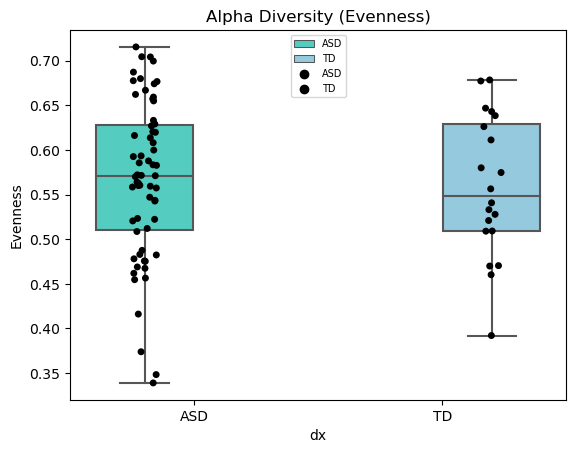

In [ ]:
sns.boxplot(x='dx', y='Evenness', data=alpha_diversity_df, hue='dx', palette=['turquoise', 'skyblue'])
sns.stripplot(x='dx', y='Evenness', data=alpha_diversity_df, hue='dx', dodge=True, jitter=True, palette=['black']) 

plt.title('Alpha Diversity (Evenness)')
plt.ylabel('Evenness')
plt.legend(loc='upper center', fontsize = "7")
plt.show()

### Rowsum

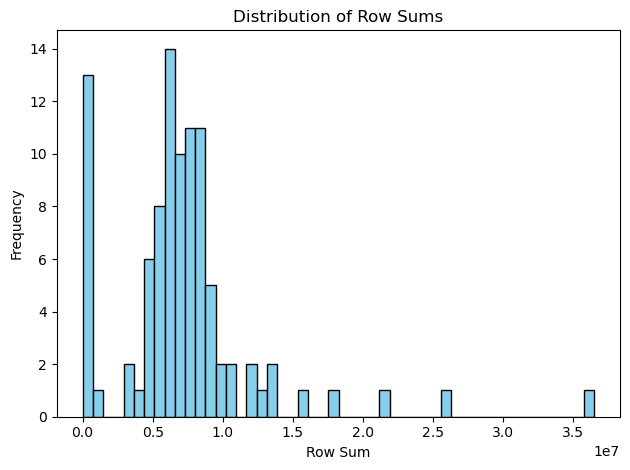

In [ ]:
from scipy.stats import norm
# Load the BIOM table
table = biom.load_table('data/195330_zebra.biom/feature-table.biom')

# Calculate the row sums
row_sums = table.sum(axis='sample')
# Create a histogram of the row sums
plt.hist(row_sums, bins=50, edgecolor='black', color = "skyblue")
plt.xlabel('Row Sum')
plt.ylabel('Frequency')
plt.title('Distribution of Row Sums')
plt.tight_layout()
plt.show()

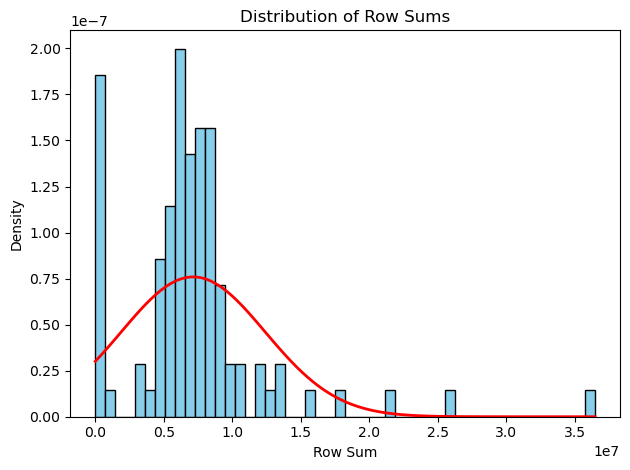

In [ ]:
# Load the BIOM table
table = biom.load_table('data/195330_zebra.biom/feature-table.biom')

# Calculate the row sums
row_sums = table.sum(axis='sample')

# Create a histogram of the row sums
plt.hist(row_sums, bins=50, edgecolor='black', color="skyblue", density=True)

# Calculate the mean and standard deviation of the row sums
mean = row_sums.mean()
std = row_sums.std()

# Generate x-values for the normal distribution line
x = np.linspace(min(row_sums), max(row_sums), 100)

# Calculate the y-values for the normal distribution line
y = norm.pdf(x, mean, std)

# Plot the normal distribution line
plt.plot(x, y, color='red', linewidth=2)

plt.xlabel('Row Sum')
plt.ylabel('Density')
plt.title('Distribution of Row Sums')
plt.tight_layout()
plt.show()

### Calculating RPCA

In [2]:
from biom import load_table
from gemelli.rpca import rpca

In [ ]:
# import the data table
table = load_table("data/195330_zebra.biom/feature-table.biom")

# lucas's biom table
# table = load_table("out/lucas/195330_zebra.biom")


# perform RPCA
ordination, distance = rpca(table, min_sample_count=500)


/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


In [ ]:
from gemelli.utils import qc_rarefaction

rare_ordination, rare_distance = rpca(table.copy().subsample(500))
t, p = qc_rarefaction(table, rare_distance, distance)
(t, p)

/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


(-0.7083401078841698, 0.48071870656156057)

In [3]:
!qiime gemelli rpca \
    --i-table data/195330_zebra.qza \
    --p-min-sample-count 500 \
    --o-biplot data/ordination.qza \
    --o-distance-matrix data/distance.qza

Usage: qiime gemelli rpca [OPTIONS]

  Performs robust center log-ratio transform robust PCA and ranks the features
  by the loadings of the resulting SVD.

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency]
                       The feature table containing the samples over which
                       metric should be computed.                   [required]
Parameters:
  --p-n-components INTEGER
                       The underlying low-rank structure. The input can be an
                       integer (suggested: 1 < rank < 10) [minimum 2]. Note:
                       as the rank increases the runtime will increase
                       dramatically.                              [default: 3]
  --p-min-sample-count INTEGER
                       Minimum sum cutoff of sample across all features. The
                       value can be at minimum zero and must be an whole
                       integer. It is suggested to be greater than or equal to
                       500.     

In [ ]:
!qiime feature-table rarefy \
    --i-table data/195330_zebra.qza \
    --p-sampling-depth 500 \
    --o-rarefied-table  data/rarefy-table.qza \

Saved FeatureTable[Frequency] to: data/rarefy-table.qza


In [ ]:
!qiime gemelli rpca \
    --i-table data/rarefy-table.qza \
    --o-biplot data/rarefy-ordination.qza \
    --o-distance-matrix data/rarefy-distance.qza

Saved PCoAResults % Properties('biplot') to: data/rarefy-ordination.qza
Saved DistanceMatrix to: data/rarefy-distance.qza


In [ ]:
!qiime gemelli qc-rarefy \
    --i-table data/195330_zebra.qza \
    --i-rarefied-distance data/rarefy-distance.qza \
    --i-unrarefied-distance data/distance.qza \
    --o-visualization data/rarefy-qc.qzv

Plugin error from gemelli:

  [Errno 2] No such file or directory: '/home/l1joseph/miniforge3/envs/qiime2-shotgun-2024.2/lib/python3.8/site-packages/gemelli/q2/qc_assests/index.html'

Debug info has been saved to /tmp/qiime2-q2cli-err-9u9l5bby.log


In [5]:
!qiime emperor biplot \
    --i-biplot data/wolr2/zebra30/rpca/ordination.qza \
    --m-sample-metadata-file data/metadata/Metadata.tsv \
    --o-visualization data/wolr2/zebra30/rpca/biplot_50.qzv \
    --p-number-of-features 50


# --m-feature-metadata-file qiime2-moving-pictures-tutorial/taxonomy.qza \

Saved Visualization to: data/wolr2/zebra30/rpca/biplot_50.qzv


## QURRO
note: Switch to merged qiime2 environement ( I used qiime2-2023.2)